In [303]:
from data_preprocessing import *
import matplotlib.pyplot as plt
import numpy as np

In [304]:
"""
Pre-Processing:

Splitting data into:
- regenerative and propulsive regimes by I_M (current) values
- blade angles: 15 and 30 deg
- AoA: steps of 2 between and including -12 and 12 deg
- J: between 0.55-1.50 for beta 15 deg
- J: between 0.90-2.10 for beta 30 deg

Final number of arrays is 52:
- 13 propulsive beta = 15 deg: alpha -12 to 12 deg, 0.55<=J<=1.50
- 13 propulsive beta = 30 deg: alpha -12 to 12 deg, 0.55<=J<=1.50
- 13 regen beta = 15 deg: alpha -12 to 12 deg, 0.90<=J<=2.10
- 13 regen beta = 30 deg: alpha -12 to 12 deg, 0.90<=J<=2.10
"""

# Retrieve Indices of Relevant Columns for Pre-Processing
column_headers = [
    'DPN', 'time', 'p_Atm', 'T_atm', 'rho_atm', 'mu_atm', 'gamma_atm', 'Qinf',
    'Vinf', 'AoA', 'beta', 'RPS_M', 'StdDevRPS', 'J', 'V_M', 'I_M', 'T_M',
    'PSus', 'PTus', 'FX_I', 'FY_I', 'FZ_I', 'MX_I', 'MY_I', 'MZ_I', 'FX_E',
    'FY_E', 'FZ_E', 'MX_E', 'MY_E', 'MZ_E'
]

V_index = column_headers.index('Vinf')
alpha_index = column_headers.index('AoA')
beta_index = column_headers.index('beta')
J_index = column_headers.index('J')
FZ_E_index = column_headers.index('FZ_E')
rho_index = column_headers.index('rho_atm')
n_index = column_headers.index('RPS_M')
Q_index = column_headers.index('MZ_E')
Q_index_int = column_headers.index('MZ_I')

D = 0.4064  # diameter of propeller in m

# split into propulsive and regenerative regimes based on value of current, 'I_M'
data_propulsive, data_regen = filter_prop_regen(excel_path)

# split propulsive and regenerative regimes into 20, 30, 40, and other m/s
prop_18_22, prop_28_32, prop_38_42, prop_other = sort_Vinf(
    data_propulsive, V_index)
regen_18_22, regen_28_32, regen_38_42, regen_other = sort_Vinf(
    data_regen, V_index)

# sort based on alpha range -12 to 12
prop_V30 = sort_alpha_range(prop_28_32, alpha_index)
regen_V30 = sort_alpha_range(regen_28_32, alpha_index)

# sort based on beta
prop_V30_beta15, prop_V30_beta30 = sort_beta(prop_V30, beta_index)
regen_V30_beta15, regen_V30_beta30 = sort_beta(regen_V30, beta_index)

# sort based on J as specified per beta in reader
prop_V30_beta15 = sort_J(prop_V30_beta15, J_index, 0.55, 1.50)
prop_V30_beta30 = sort_J(prop_V30_beta30, J_index, 0.90, 2.10)
regen_V30_beta15 = sort_J(regen_V30_beta15, J_index, 0.55, 1.50)
regen_V30_beta30 = sort_J(regen_V30_beta30, J_index, 0.90, 2.10)

# problem because we don't get the full range of J for each regime
print(min(prop_V30_beta15[:, J_index]), '<= J prop V30 beta 15 <=',
      max(prop_V30_beta15[:, J_index]))
print(min(prop_V30_beta30[:, J_index]), '<= J prop V30 beta 30 <=',
      max(prop_V30_beta30[:, J_index]))
print(min(regen_V30_beta15[:, J_index]), '<= J regen V30 beta 15 <=',
      max(regen_V30_beta15[:, J_index]))
print(min(regen_V30_beta30[:, J_index]), '<= J regen V30 beta 30 <=',
      max(regen_V30_beta30[:, J_index]))

0.54959850465058 <= J prop V30 beta 15 <= 0.80140815880632
0.9056226306014 <= J prop V30 beta 30 <= 1.4937003851442
0.88191007530343 <= J regen V30 beta 15 <= 1.4861715935361
1.4356927111924 <= J regen V30 beta 30 <= 2.0873421668885


In [305]:
# for each operational condition where V, beta, and prop/regen are constant, sort into bins of J
J_arrays_prop_V30_beta15 = sort_J_bin(prop_V30_beta15, J_index)    
J_arrays_prop_V30_beta30 = sort_J_bin(prop_V30_beta30, J_index)
J_arrays_regen_V30_beta15 = sort_J_bin(regen_V30_beta15, J_index)
J_arrays_regen_V30_beta30 = sort_J_bin(regen_V30_beta30, J_index)   

# move fake propulsive to regen for beta 15
print(len(J_arrays_regen_V30_beta15))
J_arrays_regen_V30_beta15.append(J_arrays_prop_V30_beta15[-1])
J_arrays_regen_V30_beta15.append(J_arrays_prop_V30_beta15[-2])
J_arrays_regen_V30_beta15.append(J_arrays_prop_V30_beta15[-3])
print(len(J_arrays_regen_V30_beta15))
print(len(J_arrays_prop_V30_beta15))
J_arrays_prop_V30_beta15 = np.delete(J_arrays_prop_V30_beta15, [-1,-2, -3])
print(len(J_arrays_prop_V30_beta15))

# move fake propulsive to regen for beta 30
print(len(J_arrays_regen_V30_beta30))
J_arrays_regen_V30_beta30.append(J_arrays_prop_V30_beta30[-1])
J_arrays_regen_V30_beta30.append(J_arrays_prop_V30_beta30[-2])

print(len(J_arrays_regen_V30_beta30))
print(len(J_arrays_prop_V30_beta30))
J_arrays_prop_V30_beta30 = np.delete(J_arrays_prop_V30_beta30, [-1, -2])

print(len(J_arrays_prop_V30_beta30))




13
16
7
4
14
16
13
11


/usr/lib/python3/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [306]:
# remove empty J bins arrays
J_arrays_prop_V30_beta15 = [arr for arr in J_arrays_prop_V30_beta15 if arr.shape[0] > 1]
J_arrays_prop_V30_beta30 = [arr for arr in J_arrays_prop_V30_beta30 if arr.shape[0] > 1]
J_arrays_regen_V30_beta15 = [arr for arr in J_arrays_regen_V30_beta15 if arr.shape[0] > 1]
J_arrays_regen_V30_beta30 = [arr for arr in J_arrays_regen_V30_beta30 if arr.shape[0] > 1]



In [307]:
# Define the thrust coefficent
# # According to Experimental Analysis of a Small-Scale Rotor at Various Inflow Angles (Kolaei, 2018)
# def thrust_coeff(T, rho, n, D):
#   C_T = -16 * T / (rho * np.pi * n**2 * D**4)
#   return C_T

# According to MIT https://web.mit.edu/16.unified/www/FALL/thermodynamics/notes/node86.html#SECTION06374300000000000000
def thrust_coeff(T, rho, n, D):
  C_T = -T / (rho * n**2 * D**4)
  return C_T

# Dedfine the power coefficient
# According to Experimental Analysis of a Small-Scale Rotor at Various Inflow Angles (Kolaei, 2018)
# def power_coeff(Q, rho, n, D):
#   C_P = -32 * Q / (rho * np.pi * n**2 * D**5)
#   return C_P

# According to MIT https://web.mit.edu/16.unified/www/FALL/thermodynamics/notes/node86.html#SECTION06374300000000000000
def power_coeff(Q, rho, n, D):
  C_P = Q / (rho * n**2 * D**5)
  return C_P

# According to MIT https://web.mit.edu/16.unified/www/FALL/thermodynamics/notes/node86.html#SECTION06374300000000000000
def efficiency(C_T, J, C_P):
    propulsive_eff = (C_T / C_P) * (1) * J / (2*np.pi)
    return propulsive_eff

def efficiency2(T, u0, Q, n):
    propulsive_eff = T * u0 / (2*np.pi*n*Q)
    return propulsive_eff



In [308]:

# calculate C_T, C_P, eff and add to each array
for J_array in range(len(J_arrays_prop_V30_beta15)):
    # calculate C_T using def thrust_coeff(T, rho, n, D) and add C_T column to J_array
    C_T = thrust_coeff(J_arrays_prop_V30_beta15[J_array][:, FZ_E_index], J_arrays_prop_V30_beta15[J_array][:, rho_index], J_arrays_prop_V30_beta15[J_array][:, n_index], D)
    C_P = power_coeff(J_arrays_prop_V30_beta15[J_array][:, Q_index_int], J_arrays_prop_V30_beta15[J_array][:, rho_index], J_arrays_prop_V30_beta15[J_array][:, n_index], D)
    # EFF = efficiency(C_T, J_arrays_prop_V30_beta15[J_array][:, J_index], C_P)
    EFF = efficiency2(J_arrays_prop_V30_beta15[J_array][:, FZ_E_index], 30, J_arrays_prop_V30_beta15[J_array][:, Q_index_int], J_arrays_prop_V30_beta15[J_array][:, n_index])
    # efficiencies = np.clip(efficiencies, -1, 1) # limit efficiencies to be between -1 and 1
    J_arrays_prop_V30_beta15[J_array] = np.column_stack((J_arrays_prop_V30_beta15[J_array], C_T))
    J_arrays_prop_V30_beta15[J_array] = np.column_stack((J_arrays_prop_V30_beta15[J_array], C_P))
    J_arrays_prop_V30_beta15[J_array] = np.column_stack((J_arrays_prop_V30_beta15[J_array], EFF))

# calculate C_T, C_P, eff and add to each array
for J_array in range(len(J_arrays_prop_V30_beta30)):
    # calculate C_T using def thrust_coeff(T, rho, n, D) and add C_T column to J_array
    C_T = thrust_coeff(J_arrays_prop_V30_beta30[J_array][:, FZ_E_index], J_arrays_prop_V30_beta30[J_array][:, rho_index], J_arrays_prop_V30_beta30[J_array][:, n_index], D)
    C_P = power_coeff(J_arrays_prop_V30_beta30[J_array][:, Q_index_int], J_arrays_prop_V30_beta30[J_array][:, rho_index], J_arrays_prop_V30_beta30[J_array][:, n_index], D)
    # EFF = efficiency(C_T, J_arrays_prop_V30_beta30[J_array][:, J_index], C_P)
    EFF = efficiency2(J_arrays_prop_V30_beta30[J_array][:, FZ_E_index], 30, J_arrays_prop_V30_beta30[J_array][:, Q_index_int], J_arrays_prop_V30_beta30[J_array][:, n_index])
    # efficiencies = np.clip(efficiencies, -1, 1) # limit efficiencies to be between -1 and 1
    J_arrays_prop_V30_beta30[J_array] = np.column_stack((J_arrays_prop_V30_beta30[J_array], C_T))
    J_arrays_prop_V30_beta30[J_array] = np.column_stack((J_arrays_prop_V30_beta30[J_array], C_P))
    J_arrays_prop_V30_beta30[J_array] = np.column_stack((J_arrays_prop_V30_beta30[J_array], EFF))

# calculate C_T, C_P, eff and add to each array
for J_array in range(len(J_arrays_regen_V30_beta15)):
    # calculate C_T using def thrust_coeff(T, rho, n, D) and add C_T column to J_array
    C_T = thrust_coeff(J_arrays_regen_V30_beta15[J_array][:, FZ_E_index], J_arrays_regen_V30_beta15[J_array][:, rho_index], J_arrays_regen_V30_beta15[J_array][:, n_index], D)
    C_P = power_coeff(J_arrays_regen_V30_beta15[J_array][:, Q_index_int], J_arrays_regen_V30_beta15[J_array][:, rho_index], J_arrays_regen_V30_beta15[J_array][:, n_index], D)
    # EFF = efficiency(C_T, J_arrays_prop_V30_beta30[J_array][:, J_index], C_P)
    EFF = efficiency2(J_arrays_regen_V30_beta15[J_array][:, FZ_E_index], 30, J_arrays_regen_V30_beta15[J_array][:, Q_index_int], J_arrays_regen_V30_beta15[J_array][:, n_index])
    # efficiencies = np.clip(efficiencies, -1, 1) # limit efficiencies to be between -1 and 1
    J_arrays_regen_V30_beta15[J_array] = np.column_stack((J_arrays_regen_V30_beta15[J_array], C_T))
    J_arrays_regen_V30_beta15[J_array] = np.column_stack((J_arrays_regen_V30_beta15[J_array], C_P))
    J_arrays_regen_V30_beta15[J_array] = np.column_stack((J_arrays_regen_V30_beta15[J_array], EFF))


# calculate C_T, C_P, eff and add to each array
for J_array in range(len(J_arrays_regen_V30_beta30)):
    # calculate C_T using def thrust_coeff(T, rho, n, D) and add C_T column to J_array
    C_T = thrust_coeff(J_arrays_regen_V30_beta30[J_array][:, FZ_E_index], J_arrays_regen_V30_beta30[J_array][:, rho_index], J_arrays_regen_V30_beta30[J_array][:, n_index], D)
    C_P = power_coeff(J_arrays_regen_V30_beta30[J_array][:, Q_index_int], J_arrays_regen_V30_beta30[J_array][:, rho_index], J_arrays_regen_V30_beta30[J_array][:, n_index], D)
    # EFF = efficiency(C_T, J_arrays_prop_V30_beta30[J_array][:, J_index], C_P)
    EFF = efficiency2(J_arrays_regen_V30_beta30[J_array][:, FZ_E_index], 30, J_arrays_regen_V30_beta30[J_array][:, Q_index_int], J_arrays_regen_V30_beta30[J_array][:, n_index])
    # efficiencies = np.clip(efficiencies, -1, 1) # limit efficiencies to be between -1 and 1
    J_arrays_regen_V30_beta30[J_array] = np.column_stack((J_arrays_regen_V30_beta30[J_array], C_T))
    J_arrays_regen_V30_beta30[J_array] = np.column_stack((J_arrays_regen_V30_beta30[J_array], C_P))
    J_arrays_regen_V30_beta30[J_array] = np.column_stack((J_arrays_regen_V30_beta30[J_array], EFF))


In [309]:
# convert to pandas dataframes for averaging of similar datapoints at same aoa and J
J_arrays_prop_V30_beta15 = [pd.DataFrame(arr) for arr in J_arrays_prop_V30_beta15]
J_arrays_prop_V30_beta30 = [pd.DataFrame(arr) for arr in J_arrays_prop_V30_beta30]
J_arrays_regen_V30_beta15 = [pd.DataFrame(arr) for arr in J_arrays_regen_V30_beta15]
J_arrays_regen_V30_beta30 = [pd.DataFrame(arr) for arr in J_arrays_regen_V30_beta30]
print(J_arrays_regen_V30_beta15[-1][J_index])

0      0.748920
1      0.748391
2      0.746161
3      0.745400
4      0.749630
         ...   
108    0.749101
109    0.749185
110    0.738044
111    0.749276
112    0.749548
Name: 13, Length: 113, dtype: float64


In [310]:
new_J_arrays_prop_V30_beta15 = []

for arr in J_arrays_prop_V30_beta15:
    # Round the 'J' column to the nearest 0.05
    arr[J_index] = np.round(np.round(arr[J_index] / 0.05) * 0.05, 2)
    # Round the 'aoa' column to the nearest 1.0
    arr[alpha_index] = np.round(arr[alpha_index])
    # Group by 'J' and 'aoa' columns and calculate the mean of other columns
    averaged_arr = arr.groupby([J_index, alpha_index]).mean()
    new_J_arrays_prop_V30_beta15.append(averaged_arr)



new_J_arrays_prop_V30_beta30 = []

for arr in J_arrays_prop_V30_beta30:
    # Round the 'J' column to the nearest 0.05
    arr[J_index] = np.round(np.round(arr[J_index] / 0.05) * 0.05, 2)
    # Round the 'aoa' column to the nearest 1.0
    arr[alpha_index] = np.round(arr[alpha_index])
    # Group by 'J' and 'aoa' columns and calculate the mean of other columns
    averaged_arr = arr.groupby([J_index, alpha_index]).mean()
    new_J_arrays_prop_V30_beta30.append(averaged_arr)

# Retrieve the index levels
index_levels = new_J_arrays_prop_V30_beta30[0].index.levels
# print(index_levels)



new_J_arrays_regen_V30_beta15 = []

for arr in J_arrays_regen_V30_beta15:
    # Round the 'J' column to the nearest 0.05
    arr[J_index] = np.round(np.round(arr[J_index] / 0.05) * 0.05, 2)
    # Round the 'aoa' column to the nearest 1.0
    arr[alpha_index] = np.round(arr[alpha_index])
    # Group by 'J' and 'aoa' columns and calculate the mean of other columns
    averaged_arr = arr.groupby([J_index, alpha_index]).mean()
    new_J_arrays_regen_V30_beta15.append(averaged_arr)


new_J_arrays_regen_V30_beta30 = []

for arr in J_arrays_regen_V30_beta30:
    # Round the 'J' column to the nearest 0.05
    arr[J_index] = np.round(np.round(arr[J_index] / 0.05) * 0.05, 2)
    # Round the 'aoa' column to the nearest 1.0
    arr[alpha_index] = np.round(arr[alpha_index])
    # Group by 'J' and 'aoa' columns and calculate the mean of other columns
    averaged_arr = arr.groupby([J_index, alpha_index]).mean()
    new_J_arrays_regen_V30_beta30.append(averaged_arr)


In [311]:
# delete J = 1.35 from prop beta 30
new_J_arrays_prop_V30_beta30 = np.delete(new_J_arrays_prop_V30_beta30, 6)

# delete J = 1.25 from regen beta 15
new_J_arrays_regen_V30_beta15 = np.delete(new_J_arrays_regen_V30_beta15, 6)

# delete J = 1.45, 1.5, 1.85 and 1.9 from regen beta 30
new_J_arrays_regen_V30_beta30 = np.delete(new_J_arrays_regen_V30_beta30, [0,-1,-2, 1,5,7])




/usr/lib/python3/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [312]:
# rearrange the new_J_arrays_regen_V30_beta15[i].index.get_level_values(0)[0] by increasing J index
index_rearrange_J_list = [-1, -2, 0, 1, 2, 3, 4, 5, 6, 7, 8]
new_J_arrays_regen_V30_beta15 = [new_J_arrays_regen_V30_beta15[-1], new_J_arrays_regen_V30_beta15[-2], new_J_arrays_regen_V30_beta15[0], new_J_arrays_regen_V30_beta15[1],new_J_arrays_regen_V30_beta15[2],new_J_arrays_regen_V30_beta15[3],new_J_arrays_regen_V30_beta15[4],new_J_arrays_regen_V30_beta15[5],new_J_arrays_regen_V30_beta15[6],new_J_arrays_regen_V30_beta15[7],new_J_arrays_regen_V30_beta15[8]]


In [313]:
array1 = new_J_arrays_prop_V30_beta30[-1]
new_J_arrays_regen_V30_beta30 = [array1, new_J_arrays_regen_V30_beta30[0],new_J_arrays_regen_V30_beta30[1],new_J_arrays_regen_V30_beta30[2],new_J_arrays_regen_V30_beta30[3],new_J_arrays_regen_V30_beta30[4],new_J_arrays_regen_V30_beta30[5]]

new_J_arrays_prop_V30_beta30 = np.delete(new_J_arrays_prop_V30_beta30, -1)

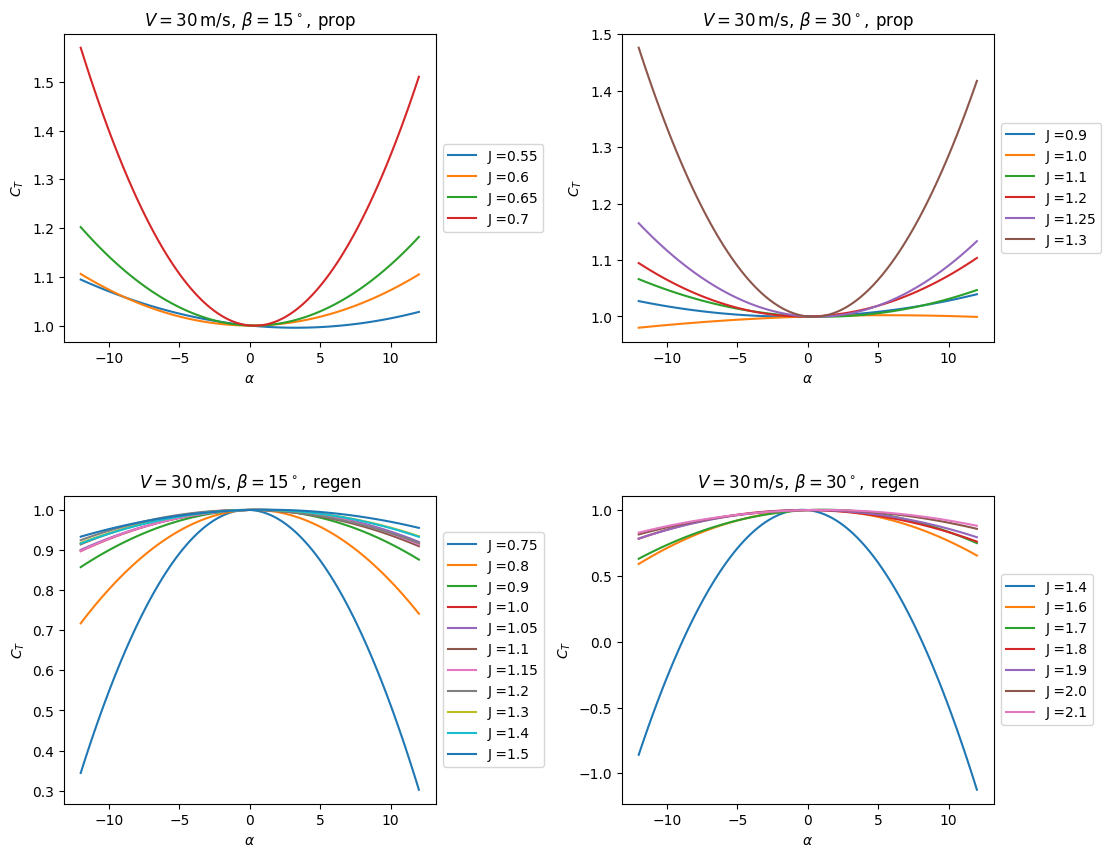

In [314]:
polynomial_order = 2
# create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# plot C_T vs alpha for each J prop V30 beta 15
axs[0, 0].set_title(r'$V = 30 \, \mathrm{m/s}, \, \beta = 15^\circ, \, \mathrm{prop}$')
for i in range(len(new_J_arrays_prop_V30_beta15)):
    C_T_index = new_J_arrays_prop_V30_beta15[i].shape[1] - 1
    J_value = new_J_arrays_prop_V30_beta15[i].index.get_level_values(0)[0]
    C_T = new_J_arrays_prop_V30_beta15[i][C_T_index]
    # C_T0 = new_J_arrays_prop_V30_beta15[i].loc[(J_value, 0.0), C_T_index]
    # C_T_ratio = C_T / C_T0

    J_label = str(round(J_value,2))
    alpha = new_J_arrays_prop_V30_beta15[i].index.get_level_values(1)
    # axs[0, 0].scatter(alpha, C_T, label='J =' + J_label)
    coeffs = np.polyfit(alpha, C_T, polynomial_order)
    curve = np.poly1d(coeffs)
    CT0 = curve(0)
    x_new = np.linspace(alpha.min(), alpha.max(), 100)
    axs[0, 0].plot(x_new, curve(x_new)/CT0, label='J =' + J_label)

axs[0, 0].set_xlabel(r'$\alpha$')
axs[0, 0].set_ylabel(r'$C_T$')
# # axs[0, 0].set_ylim([-1.3, 0.4])
axs[0, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plot C_T vs alpha for each J prop V30 beta 30
axs[0, 1].set_title(r'$V = 30 \, \mathrm{m/s}, \, \beta = 30^\circ, \, \mathrm{prop}$')
for i in range(len(new_J_arrays_prop_V30_beta30)):
    C_T_index = new_J_arrays_prop_V30_beta30[i].shape[1] - 1
    C_P_index = new_J_arrays_prop_V30_beta30[i].shape[1]
    EFF_index = new_J_arrays_prop_V30_beta30[i].shape[1] + 1
    J_value = new_J_arrays_prop_V30_beta30[i].index.get_level_values(0)[0]
    C_T = new_J_arrays_prop_V30_beta30[i][C_T_index]
    # C_T0 = new_J_arrays_prop_V30_beta30[i].loc[(J_value, 0.0), C_T_index]
    # C_T_ratio = C_T / C_T0

    J_label = str(round(J_value,2))
    alpha = new_J_arrays_prop_V30_beta30[i].index.get_level_values(1)
    # axs[0, 1].scatter(alpha, C_T, label='J =' + J_label)
    coeffs = np.polyfit(alpha, C_T, polynomial_order)
    curve = np.poly1d(coeffs)
    CT0 = curve(0)
    x_new = np.linspace(alpha.min(), alpha.max(), 100)
    axs[0, 1].plot(x_new, curve(x_new)/CT0, label='J =' + J_label)

axs[0, 1].set_xlabel(r'$\alpha$')
axs[0, 1].set_ylabel(r'$C_T$')
# # axs[0, 1].set_ylim([-1.3, 0.4])
axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plot C_T vs alpha for each J regen V30 beta 15
axs[1, 0].set_title(r'$V = 30 \, \mathrm{m/s}, \, \beta = 15^\circ, \, \mathrm{regen}$')
for i in range(len(new_J_arrays_regen_V30_beta15)):
    C_T_index = new_J_arrays_regen_V30_beta15[i].shape[1] - 1
    C_P_index = new_J_arrays_regen_V30_beta15[i].shape[1]
    EFF_index = new_J_arrays_regen_V30_beta15[i].shape[1] + 1
    J_value = new_J_arrays_regen_V30_beta15[i].index.get_level_values(0)[0]
    C_T = new_J_arrays_regen_V30_beta15[i][C_T_index]
    # C_T0 = new_J_arrays_regen_V30_beta15[i].loc[(J_value, 0.0), C_T_index]
    # C_T_ratio = C_T / C_T0

    J_label = str(round(J_value,2))
    alpha = new_J_arrays_regen_V30_beta15[i].index.get_level_values(1)
    # axs[1, 0].scatter(alpha, C_T, label='J =' + J_label)
    coeffs = np.polyfit(alpha, C_T, polynomial_order)
    curve = np.poly1d(coeffs)
    CT0 = curve(0)
    x_new = np.linspace(alpha.min(), alpha.max(), 100)
    axs[1, 0].plot(x_new, curve(x_new)/CT0, label='J =' + J_label)

axs[1, 0].set_xlabel(r'$\alpha$')
axs[1, 0].set_ylabel(r'$C_T$')
# # axs[1, 0].set_ylim([-1.3, 0.4])
axs[1, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plot C_T vs alpha for each J regen V30 beta 30
axs[1, 1].set_title(r'$V = 30 \, \mathrm{m/s}, \, \beta = 30^\circ, \, \mathrm{regen}$')
for i in range(len(new_J_arrays_regen_V30_beta30)):
    C_T_index = new_J_arrays_regen_V30_beta30[i].shape[1] - 1
    C_P_index = new_J_arrays_regen_V30_beta30[i].shape[1]
    EFF_index = new_J_arrays_regen_V30_beta30[i].shape[1] + 1
    J_value = new_J_arrays_regen_V30_beta30[i].index.get_level_values(0)[0]
    C_T = new_J_arrays_regen_V30_beta30[i][C_T_index]
    # C_T0 = new_J_arrays_regen_V30_beta30[i].loc[(J_value, 0.0), C_T_index]
    # C_T_ratio = C_T / C_T0

    J_label = str(round(J_value,2))
    alpha = new_J_arrays_regen_V30_beta30[i].index.get_level_values(1)
    # axs[1, 1].scatter(alpha, C_T, label='J =' + J_label)
    coeffs = np.polyfit(alpha, C_T, polynomial_order)
    curve = np.poly1d(coeffs)
    CT0 = curve(0)
    x_new = np.linspace(alpha.min(), alpha.max(), 100)
    axs[1, 1].plot(x_new, curve(x_new)/CT0, label='J =' + J_label)

axs[1, 1].set_xlabel(r'$\alpha$')
axs[1, 1].set_ylabel(r'$C_T$')
# # axs[1, 1].set_ylim([-1.3, 0.4])
axs[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


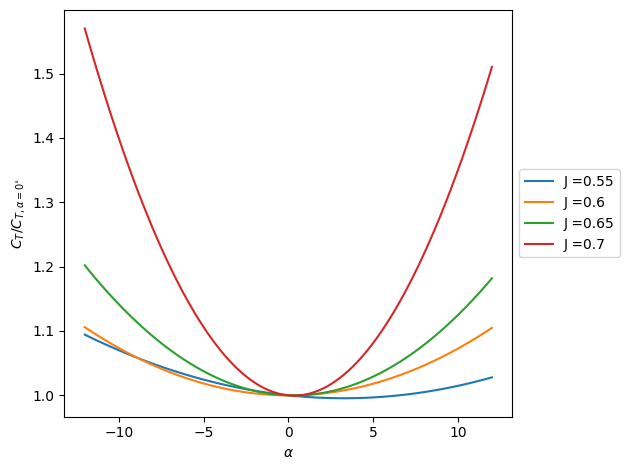

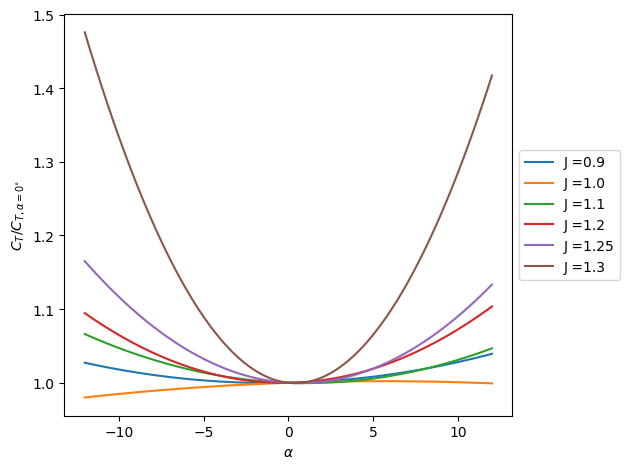

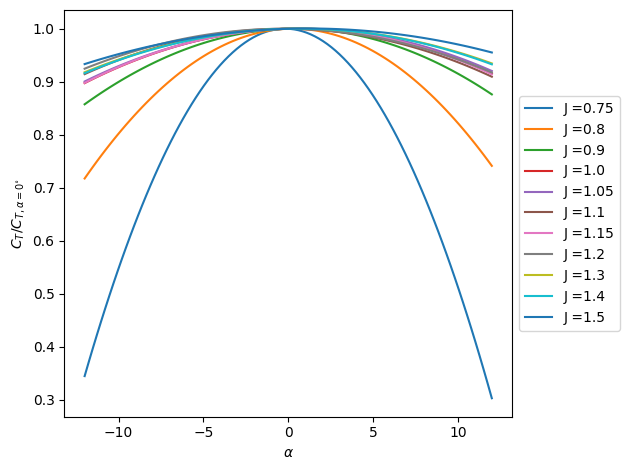

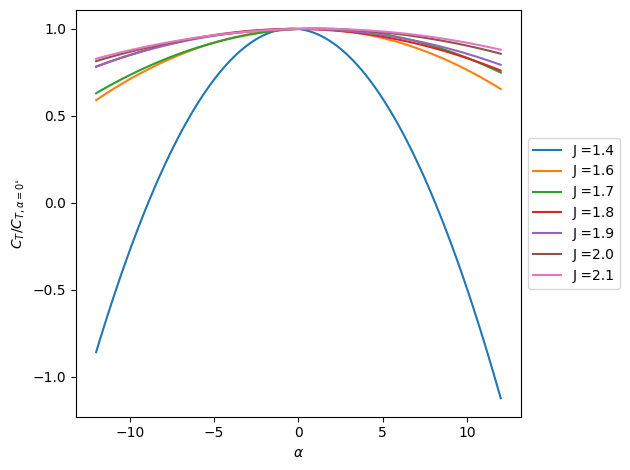

In [315]:
polynomial_order = 2

plt.figure()
# plot C_T vs alpha for each J prop V30 beta 15
for i in range(len(new_J_arrays_prop_V30_beta15)):
    C_T_index = new_J_arrays_prop_V30_beta15[i].shape[1] - 1
    J_value = new_J_arrays_prop_V30_beta15[i].index.get_level_values(0)[0]
    C_T = new_J_arrays_prop_V30_beta15[i][C_T_index]
    # C_T0 = new_J_arrays_prop_V30_beta15[i].loc[(J_value, 0.0), C_T_index]
    # C_T_ratio = C_T / C_T0

    J_label = str(round(J_value,2))
    alpha = new_J_arrays_prop_V30_beta15[i].index.get_level_values(1)
    # axs[0, 0].scatter(alpha, C_T, label='J =' + J_label)
    coeffs = np.polyfit(alpha, C_T, polynomial_order)
    curve = np.poly1d(coeffs)
    CT0 = curve(0)
    x_new = np.linspace(alpha.min(), alpha.max(), 100)
    plt.plot(x_new, curve(x_new)/CT0, label='J =' + J_label)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_T/C_{T,\alpha=0^{\circ}}$')
# # axs[0, 0].set_ylim([-1.3, 0.4])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('plots/Ct_prop_V30_beta15')

plt.figure()
# plot C_T vs alpha for each J prop V30 beta 30
for i in range(len(new_J_arrays_prop_V30_beta30)):
    C_T_index = new_J_arrays_prop_V30_beta30[i].shape[1] - 1
    C_P_index = new_J_arrays_prop_V30_beta30[i].shape[1]
    EFF_index = new_J_arrays_prop_V30_beta30[i].shape[1] + 1
    J_value = new_J_arrays_prop_V30_beta30[i].index.get_level_values(0)[0]
    C_T = new_J_arrays_prop_V30_beta30[i][C_T_index]
    # C_T0 = new_J_arrays_prop_V30_beta30[i].loc[(J_value, 0.0), C_T_index]
    # C_T_ratio = C_T / C_T0

    J_label = str(round(J_value,2))
    alpha = new_J_arrays_prop_V30_beta30[i].index.get_level_values(1)
    # plt.scatter(alpha, C_T, label='J =' + J_label)
    coeffs = np.polyfit(alpha, C_T, polynomial_order)
    curve = np.poly1d(coeffs)
    CT0 = curve(0)
    x_new = np.linspace(alpha.min(), alpha.max(), 100)
    plt.plot(x_new, curve(x_new)/CT0, label='J =' + J_label)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_T/C_{T,\alpha=0^{\circ}}$')
# plt.ylim([-1.3, 0.4])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('plots/Ct_prop_V30_beta30.png')

plt.figure()
# plot C_T vs alpha for each J regen V30 beta 15
for i in range(len(new_J_arrays_regen_V30_beta15)):
    C_T_index = new_J_arrays_regen_V30_beta15[i].shape[1] - 1
    C_P_index = new_J_arrays_regen_V30_beta15[i].shape[1]
    EFF_index = new_J_arrays_regen_V30_beta15[i].shape[1] + 1
    J_value = new_J_arrays_regen_V30_beta15[i].index.get_level_values(0)[0]
    C_T = new_J_arrays_regen_V30_beta15[i][C_T_index]
    # C_T0 = new_J_arrays_regen_V30_beta15[i].loc[(J_value, 0.0), C_T_index]
    # C_T_ratio = C_T / C_T0

    J_label = str(round(J_value,2))
    alpha = new_J_arrays_regen_V30_beta15[i].index.get_level_values(1)
    # plt.scatter(alpha, C_T, label='J =' + J_label)
    coeffs = np.polyfit(alpha, C_T, polynomial_order)
    curve = np.poly1d(coeffs)
    CT0 = curve(0)
    x_new = np.linspace(alpha.min(), alpha.max(), 100)
    plt.plot(x_new, curve(x_new)/CT0, label='J =' + J_label)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_T/C_{T,\alpha=0^{\circ}}$')
# plt.ylim([-1.3, 0.4])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('plots/Ct_regen_V30_beta15.png')


# plot C_T vs alpha for each J regen V30 beta 30
plt.figure()
for i in range(len(new_J_arrays_regen_V30_beta30)):
    C_T_index = new_J_arrays_regen_V30_beta30[i].shape[1] - 1
    C_P_index = new_J_arrays_regen_V30_beta30[i].shape[1]
    EFF_index = new_J_arrays_regen_V30_beta30[i].shape[1] + 1
    J_value = new_J_arrays_regen_V30_beta30[i].index.get_level_values(0)[0]
    C_T = new_J_arrays_regen_V30_beta30[i][C_T_index]
    # C_T0 = new_J_arrays_regen_V30_beta30[i].loc[(J_value, 0.0), C_T_index]
    # C_T_ratio = C_T / C_T0

    J_label = str(round(J_value,2))
    alpha = new_J_arrays_regen_V30_beta30[i].index.get_level_values(1)
    # plt.scatter(alpha, C_T, label='J =' + J_label)
    coeffs = np.polyfit(alpha, C_T, polynomial_order)
    curve = np.poly1d(coeffs)
    CT0 = curve(0)
    x_new = np.linspace(alpha.min(), alpha.max(), 100)
    plt.plot(x_new, curve(x_new)/CT0, label='J =' + J_label)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_T/C_{T,\alpha=0^{\circ}}$')
# plt.ylim([-1.3, 0.4])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('plots/Ct_regen_V30_beta30.png')



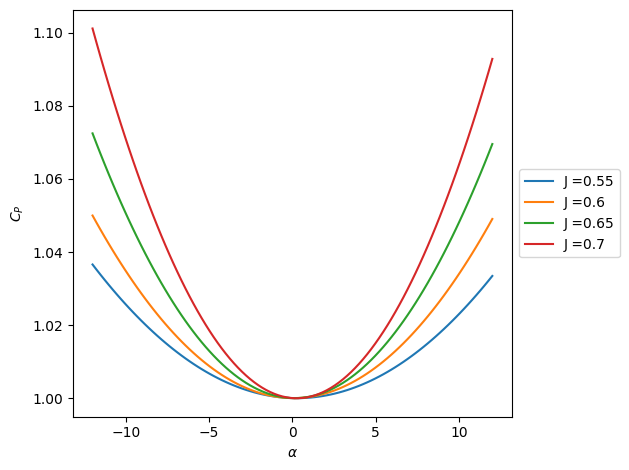

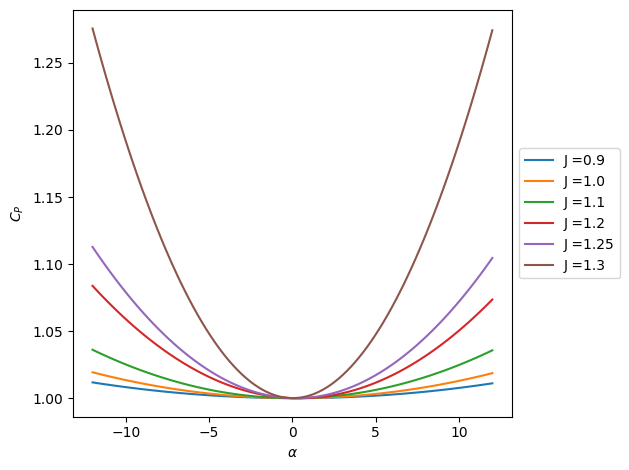

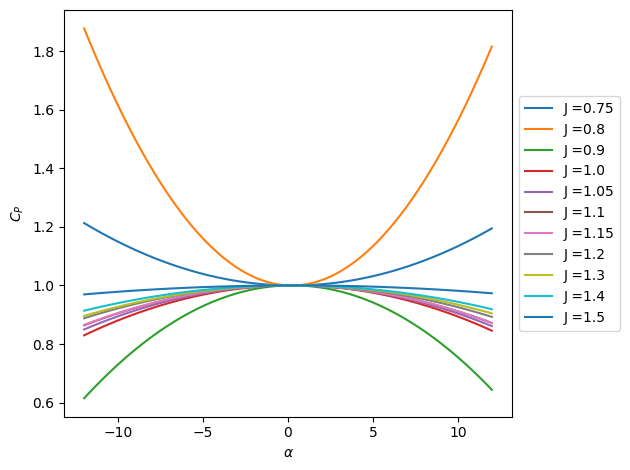

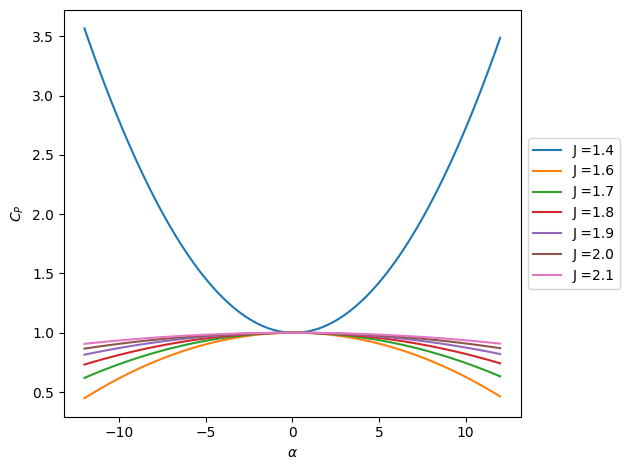

In [316]:
polynomial_order = 2

# plot C_P vs alpha for each J prop V30 beta 15
plt.figure()
for i in range(len(new_J_arrays_prop_V30_beta15)):
    C_T_index = new_J_arrays_prop_V30_beta15[i].shape[1] - 1
    C_P_index = new_J_arrays_prop_V30_beta15[i].shape[1]
    EFF_index = new_J_arrays_prop_V30_beta15[i].shape[1] + 1
    J_value = new_J_arrays_prop_V30_beta15[i].index.get_level_values(0)[0]
    C_P = new_J_arrays_prop_V30_beta15[i][C_P_index]
    # C_P0 = new_J_arrays_prop_V30_beta15[i].loc[(J_value, 0.0), C_P_index]
    # C_P_ratio = C_P / C_P0

    J_label = str(round(J_value,2))
    alpha = new_J_arrays_prop_V30_beta15[i].index.get_level_values(1)
    # plt.scatter(alpha, C_P)
    coeffs = np.polyfit(alpha, C_P, polynomial_order)
    curve = np.poly1d(coeffs)
    C_P0 = curve(0)
    x_new = np.linspace(alpha.min(), alpha.max(), 100)
    plt.plot(x_new, curve(x_new)/C_P0, label='J =' + J_label)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_P$')
# plt.ylim([-1.3, 0.4])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('plots/Cp_prop_V30_beta15.png')


# plot C_P vs alpha for each J prop V30 beta 30
plt.figure()
for i in range(len(new_J_arrays_prop_V30_beta30)):
    C_T_index = new_J_arrays_prop_V30_beta30[i].shape[1] - 1
    C_P_index = new_J_arrays_prop_V30_beta30[i].shape[1]
    EFF_index = new_J_arrays_prop_V30_beta30[i].shape[1] + 1
    J_value = new_J_arrays_prop_V30_beta30[i].index.get_level_values(0)[0]
    C_P = new_J_arrays_prop_V30_beta30[i][C_P_index]
    # C_P0 = new_J_arrays_prop_V30_beta30[i].loc[(J_value, 0.0), C_P_index]
    # C_P_ratio = C_P / C_P0

    J_label = str(round(J_value,2))
    alpha = new_J_arrays_prop_V30_beta30[i].index.get_level_values(1)
    # plt.scatter(alpha, C_P_ratio)
    coeffs = np.polyfit(alpha, C_P, polynomial_order)
    curve = np.poly1d(coeffs)
    C_P0 = curve(0)
    x_new = np.linspace(alpha.min(), alpha.max(), 100)
    plt.plot(x_new, curve(x_new)/C_P0, label='J =' + J_label)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_P$')
# plt.ylim([-1.3, 0.4])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('plots/Cp_prop_V30_beta30.png')



# plot C_P vs alpha for each J regen V30 beta 15
plt.figure()
for i in range(len(new_J_arrays_regen_V30_beta15)):
    C_T_index = new_J_arrays_regen_V30_beta15[i].shape[1] - 1
    C_P_index = new_J_arrays_regen_V30_beta15[i].shape[1]
    EFF_index = new_J_arrays_regen_V30_beta15[i].shape[1] + 1
    J_value = new_J_arrays_regen_V30_beta15[i].index.get_level_values(0)[0]
    C_P = new_J_arrays_regen_V30_beta15[i][C_P_index]
    # C_P0 = new_J_arrays_regen_V30_beta15[i].loc[(J_value, 0.0), C_P_index]
    # C_P_ratio = C_P / C_P0

    J_label = str(round(J_value,2))
    alpha = new_J_arrays_regen_V30_beta15[i].index.get_level_values(1)
    # plt.scatter(alpha, C_P_ratio)
    coeffs = np.polyfit(alpha, C_P, polynomial_order)
    curve = np.poly1d(coeffs)
    C_P0 = curve(0)
    x_new = np.linspace(alpha.min(), alpha.max(), 100)
    plt.plot(x_new, curve(x_new)/C_P0, label='J =' + J_label)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_P$')
# plt.ylim([-1.3, 0.4])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('plots/Cp_regen_V30_beta15.png')

# plot C_P vs alpha for each J regen V30 beta 30
plt.figure()
for i in range(len(new_J_arrays_regen_V30_beta30)):
    C_T_index = new_J_arrays_regen_V30_beta30[i].shape[1] - 1
    C_P_index = new_J_arrays_regen_V30_beta30[i].shape[1]
    EFF_index = new_J_arrays_regen_V30_beta30[i].shape[1] + 1
    J_value = new_J_arrays_regen_V30_beta30[i].index.get_level_values(0)[0]
    C_P = new_J_arrays_regen_V30_beta30[i][C_P_index]
    # C_P0 = new_J_arrays_regen_V30_beta30[i].loc[(J_value, 0.0), C_P_index]
    # C_P_ratio = C_P / C_P0

    J_label = str(round(J_value,2))
    alpha = new_J_arrays_regen_V30_beta30[i].index.get_level_values(1)
    # plt.scatter(alpha, C_P_ratio)
    coeffs = np.polyfit(alpha, C_P, polynomial_order)
    curve = np.poly1d(coeffs)
    C_P0 = curve(0)
    x_new = np.linspace(alpha.min(), alpha.max(), 100)
    plt.plot(x_new, curve(x_new)/C_P0, label='J =' + J_label)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_P$')
# plt.ylim([-1.3, 0.4])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('plots/Cp_regen_V30_beta30.png')




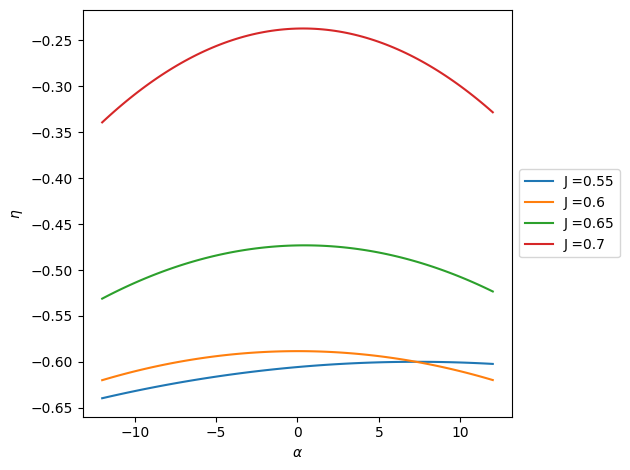

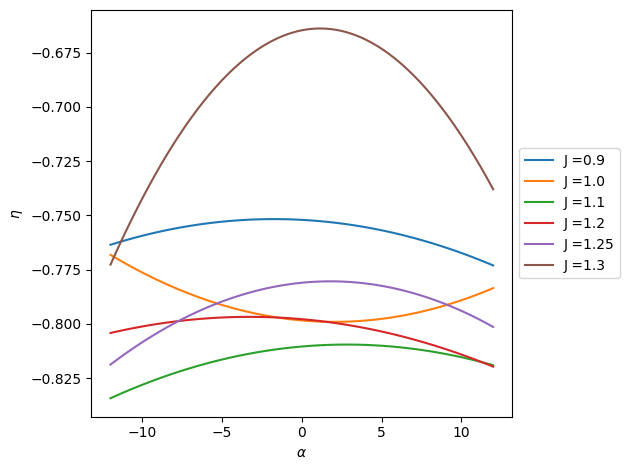

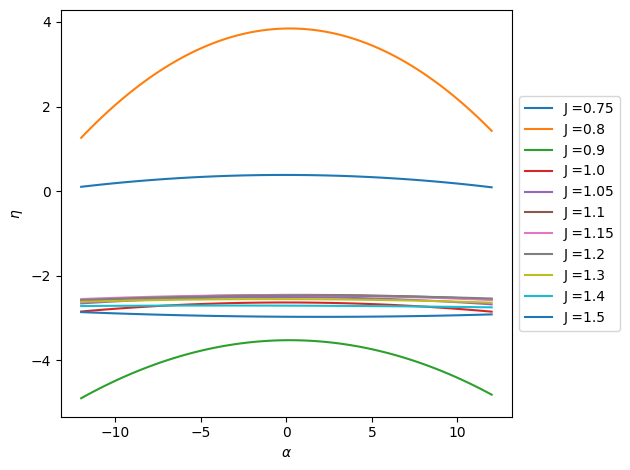

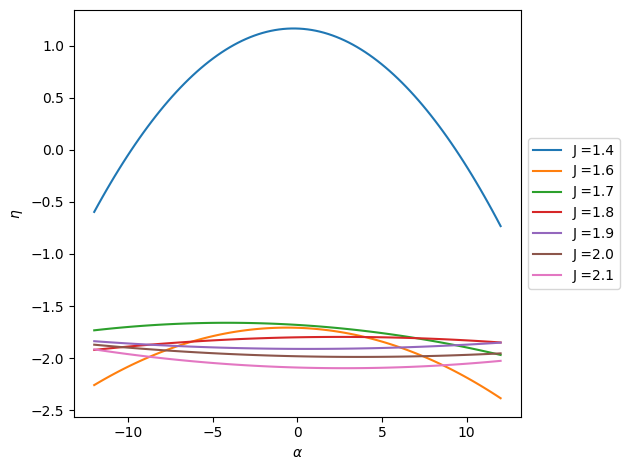

In [317]:
polynomial_order = 2

# plot C_P vs alpha for each J prop V30 beta 15
plt.figure()
for i in range(len(new_J_arrays_prop_V30_beta15)):
    C_T_index = new_J_arrays_prop_V30_beta15[i].shape[1] - 1
    C_P_index = new_J_arrays_prop_V30_beta15[i].shape[1]
    EFF_index = new_J_arrays_prop_V30_beta15[i].shape[1] + 1
    J_value = new_J_arrays_prop_V30_beta15[i].index.get_level_values(0)[0]
    EFFs = new_J_arrays_prop_V30_beta15[i][EFF_index]

    J_label = str(round(J_value,2))
    alpha = new_J_arrays_prop_V30_beta15[i].index.get_level_values(1)
    # plt.scatter(alpha, EFFs, label=J_label)
    coeffs = np.polyfit(alpha, EFFs, polynomial_order)
    curve = np.poly1d(coeffs)
    x_new = np.linspace(alpha.min(), alpha.max(), 100)
    plt.plot(x_new, curve(x_new), label='J =' + J_label)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\eta$')
# plt.ylim([-1.3, 0.4])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('plots/Eff_prop_V30_beta15.png')


# plot C_P vs alpha for each J prop V30 beta 390
plt.figure()
for i in range(len(new_J_arrays_prop_V30_beta30)):
    C_T_index = new_J_arrays_prop_V30_beta30[i].shape[1] - 1
    C_P_index = new_J_arrays_prop_V30_beta30[i].shape[1]
    EFF_index = new_J_arrays_prop_V30_beta30[i].shape[1] + 1
    J_value = new_J_arrays_prop_V30_beta30[i].index.get_level_values(0)[0]
    EFFs = new_J_arrays_prop_V30_beta30[i][EFF_index]

    J_label = str(round(J_value,2))
    alpha = new_J_arrays_prop_V30_beta30[i].index.get_level_values(1)
    # plt.scatter(alpha, EFFs, label=J_label)
    coeffs = np.polyfit(alpha, EFFs, polynomial_order)
    curve = np.poly1d(coeffs)
    x_new = np.linspace(alpha.min(), alpha.max(), 100)
    plt.plot(x_new, curve(x_new), label='J =' + J_label)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\eta$')
# plt.ylim([-1.3, 0.4])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('plots/Eff_prop_V30_beta30.png')


# plot C_P vs alpha for each J regen V30 beta 15
plt.figure()
for i in range(len(new_J_arrays_regen_V30_beta15)):
    C_T_index = new_J_arrays_regen_V30_beta15[i].shape[1] - 1
    C_P_index = new_J_arrays_regen_V30_beta15[i].shape[1]
    EFF_index = new_J_arrays_regen_V30_beta15[i].shape[1] + 1
    J_value = new_J_arrays_regen_V30_beta15[i].index.get_level_values(0)[0]
    EFFs = new_J_arrays_regen_V30_beta15[i][EFF_index]

    J_label = str(round(J_value,2))
    alpha = new_J_arrays_regen_V30_beta15[i].index.get_level_values(1)
    # plt.scatter(alpha, EFFs, label=J_label)
    coeffs = np.polyfit(alpha, EFFs, polynomial_order)
    curve = np.poly1d(coeffs)
    x_new = np.linspace(alpha.min(), alpha.max(), 100)
    plt.plot(x_new, curve(x_new), label='J =' + J_label)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\eta$')
# plt.ylim([-1.3, 0.4])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('plots/Eff_regen_V30_beta15.png')

# plot C_P vs alpha for each J regen V30 beta 30
plt.figure()
for i in range(len(new_J_arrays_regen_V30_beta30)):
    C_T_index = new_J_arrays_regen_V30_beta30[i].shape[1] - 1
    C_P_index = new_J_arrays_regen_V30_beta30[i].shape[1]
    EFF_index = new_J_arrays_regen_V30_beta30[i].shape[1] + 1
    J_value = new_J_arrays_regen_V30_beta30[i].index.get_level_values(0)[0]
    EFFs = new_J_arrays_regen_V30_beta30[i][EFF_index]

    J_label = str(round(J_value,2))
    alpha = new_J_arrays_regen_V30_beta30[i].index.get_level_values(1)
    # plt.scatter(alpha, EFFs, label=J_label)
    coeffs = np.polyfit(alpha, EFFs, polynomial_order)
    curve = np.poly1d(coeffs)
    x_new = np.linspace(alpha.min(), alpha.max(), 100)
    plt.plot(x_new, curve(x_new), label='J =' + J_label)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\eta$')
# plt.ylim([-1.3, 0.4])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('plots/Eff_regen_V30_beta30.png')




In [318]:
# # create 2x2 subplots
# fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # plot eff vs alpha for each J prop V30 beta 15
# axs[0, 0].set_title(r'$V = 30 \, \mathrm{m/s}, \, \beta = 15^\circ, \, \mathrm{prop}$')
# for i in range(len(J_arrays_prop_V30_beta15)):
#     J_label = str(round(round(J_arrays_prop_V30_beta15[i][:, J_index][0] / 0.05) * 0.05, 2))
#     axs[0, 0].scatter(J_arrays_prop_V30_beta15[i][:, alpha_index], J_arrays_prop_V30_beta15[i][:, -1], label='J =' + J_label)
# axs[0, 0].set_xlabel(r'$\alpha$')
# axs[0, 0].set_ylabel(r'$\eta$')
# # axs[0, 0].set_ylim([-1.0, 1.0])
# axs[0, 0].legend()

# # plot eff vs alpha for each J prop V30 beta 30
# axs[0, 1].set_title(r'$V = 30 \, \mathrm{m/s}, \, \beta = 30^\circ, \, \mathrm{prop}$')
# for i in range(len(J_arrays_regen_V30_beta30)):
#     J_label = str(round(round(J_arrays_regen_V30_beta30[i][:, J_index][0] / 0.05) * 0.05, 2))
#     axs[0, 1].scatter(J_arrays_regen_V30_beta30[i][:, alpha_index], J_arrays_regen_V30_beta30[i][:, -1], label='J =' + J_label)
# axs[0, 1].set_xlabel(r'$\alpha$')
# axs[0, 1].set_ylabel(r'$\eta$')
# # axs[0, 1].set_ylim([-1.0, 1.0])
# axs[0, 1].legend()

# # plot eff vs alpha for each J regen V30 beta 15
# axs[1, 0].set_title(r'$V = 30 \, \mathrm{m/s}, \, \beta = 15^\circ, \, \mathrm{regen}$')
# for i in range(len(J_arrays_regen_V30_beta15)):
#     J_label = str(round(round(J_arrays_regen_V30_beta15[i][:, J_index][0] / 0.05) * 0.05, 2))
#     axs[1, 0].scatter(J_arrays_regen_V30_beta15[i][:, alpha_index], J_arrays_regen_V30_beta15[i][:, -1], label='J =' + J_label)
# axs[1, 0].set_xlabel(r'$\alpha$')
# axs[1, 0].set_ylabel(r'$\eta$')
# # axs[1, 0].set_ylim([-1.0, 1.0])
# axs[1, 0].legend()

# # plot eff vs alpha for each J regen V30 beta 30
# axs[1, 1].set_title(r'$V = 30 \, \mathrm{m/s}, \, \beta = 30^\circ, \, \mathrm{regen}$')
# for i in range(len(J_arrays_regen_V30_beta30)):
#     J_label = str(round(round(J_arrays_regen_V30_beta30[i][:, J_index][0] / 0.05) * 0.05, 2))
#     axs[1, 1].scatter(J_arrays_regen_V30_beta30[i][:, alpha_index], J_arrays_regen_V30_beta30[i][:, -1], label='J =' + J_label)
# axs[1, 1].set_xlabel(r'$\alpha$')
# axs[1, 1].set_ylabel(r'$\eta$')
# # axs[1, 1].set_ylim([-1.0, 1.0])
# axs[1, 1].legend()
